In [2]:
!wget --no-check-certificate \
    https://github.com/omidmno2/stockMarketPrediction_DL/raw/main/tse_en.csv \
    -o /tmp/tse_en.csv

In [92]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

In [112]:
df = pd.read_csv("tse_en.csv")
df[df.Symbol == "خرينگ"]

,Date,Symbol,Name,Yesterday,Open,Last,Close,Close Changes,Low,High,Number Traded,Volume,Value Traded
106,2008-12-07,خرينگ,رينگ‌سازي‌مشهد,871,845,845,871,0,845.0,845.0,1,1161,981045
4433,2009-02-01,خرينگ,رينگ‌سازي‌مشهد,871,845,845,861,-10,845.0,845.0,7,31464,26587080
5184,2009-02-09,خرينگ,رينگ‌سازي‌مشهد,861,836,836,860,-1,836.0,836.0,2,2000,1672000
5634,2009-02-17,خرينگ,رينگ‌سازي‌مشهد,860,835,835,860,0,835.0,835.0,1,100,83500
7046,2009-03-08,خرينگ,رينگ‌سازي‌مشهد,860,835,835,835,-25,835.0,835.0,1,25,20875
...,...,...,...,...,...,...,...,...,...,...,...,...,...
817588,2021-06-22,خرينگ,رينگ‌سازي‌مشهد,41060,39010,39010,40310,-750,39010.0,39010.0,158,117610,4587966100
817981,2021-06-23,خرينگ,رينگ‌سازي‌مشهد,40310,38300,38910,39440,-870,38300.0,41700.0,5677,10229411,403442781240
818069,2021-06-26,خرينگ,رينگ‌سازي‌مشهد,39440,39000,41410,41300,1860,39000.0,41410.0,1310,2325960,96055071260
818487,2021-06-27,خرينگ,رينگ‌سازي‌مشهد,41300,43360,42700,42860,1560,39300.0,43360.0,3494,4640427,198878791180


In [113]:
data = df[df.Symbol == "خرينگ"]
data.index = pd.to_datetime(data['Date'])
data = data.drop(columns=['Symbol', 'Name', 'Date']).dropna()
data = data.head(2300)

In [114]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

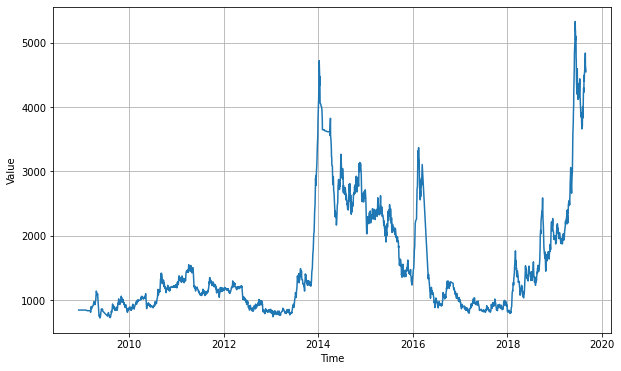

In [115]:
# Normal data

series = np.array(data.Last)
time = np.array(data.index)
plt.figure(figsize=(10, 6))
plot_series(time, series)

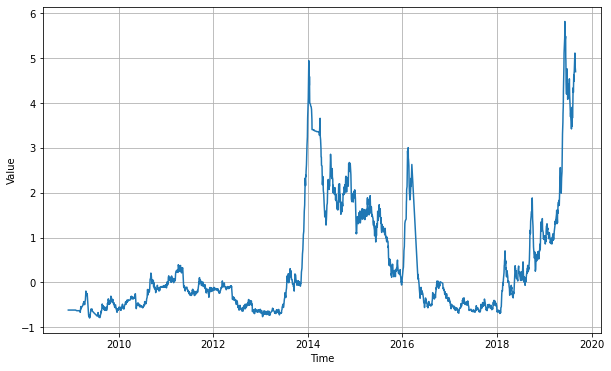

In [116]:
# Standardized Data

series = data['Last'].values.reshape(-1, 1)
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

series = np.array(series)
time = np.array(data.index)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [117]:
split_time = 2000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [118]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [119]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [120]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2000,)
Epoch 1/100
62/62 [==============================] - 7s 42ms/step - loss: 1.9323 - mae: 2.3692 - lr: 1.0000e-08
Epoch 2/100
62/62 [==============================] - 3s 41ms/step - loss: 1.6079 - mae: 2.0539 - lr: 1.1220e-08
Epoch 3/100
62/62 [==============================] - 3s 41ms/step - loss: 1.4071 - mae: 1.8552 - lr: 1.2589e-08
Epoch 4/100
62/62 [==============================] - 3s 41ms/step - loss: 1.2546 - mae: 1.7040 - lr: 1.4125e-08
Epoch 5/100
62/62 [==============================] - 3s 41ms/step - loss: 1.1298 - mae: 1.5769 - lr: 1.5849e-08
Epoch 6/100
62/62 [==============================] - 3s 44ms/step - loss: 1.0238 - mae: 1.4679 - lr: 1.7783e-08
Epoch 7/100
62/62 [==============================] - 3s 46ms/step - loss: 0.9304 - mae: 1.3666 - lr: 1.9953e-08
Epoch 8/100
62/62 [==============================] - 3s 47ms/step - loss: 0.8454 - mae: 1.2705 - lr: 2.2387e-08
Ep

(1e-08, 0.0001, 0.0, 0.2)

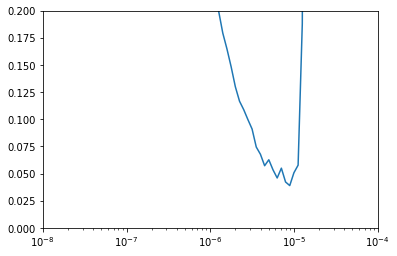

In [121]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 0.2])

In [122]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=256, kernel_size=5,
                         strides=1, padding="causal",
                         activation="relu",
                         input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(learning_rate=9e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)

Epoch 1/150
62/62 [==============================] - 9s 59ms/step - loss: 0.6557 - mae: 0.9738
Epoch 2/150
62/62 [==============================] - 4s 58ms/step - loss: 0.0534 - mae: 0.2214
Epoch 3/150
62/62 [==============================] - 4s 58ms/step - loss: 0.0280 - mae: 0.1519
Epoch 4/150
62/62 [==============================] - 4s 57ms/step - loss: 0.0253 - mae: 0.1468
Epoch 5/150
62/62 [==============================] - 4s 57ms/step - loss: 0.0230 - mae: 0.1398
Epoch 6/150
62/62 [==============================] - 4s 59ms/step - loss: 0.0188 - mae: 0.1209
Epoch 7/150
62/62 [==============================] - 4s 57ms/step - loss: 0.0203 - mae: 0.1311
Epoch 8/150
62/62 [==============================] - 4s 56ms/step - loss: 0.0168 - mae: 0.1138
Epoch 9/150
62/62 [==============================] - 4s 58ms/step - loss: 0.0159 - mae: 0.1099
Epoch 10/150
62/62 [==============================] - 4s 56ms/step - loss: 0.0156 - mae: 0.1097
Epoch 11/150
62/62 [=============================

In [123]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

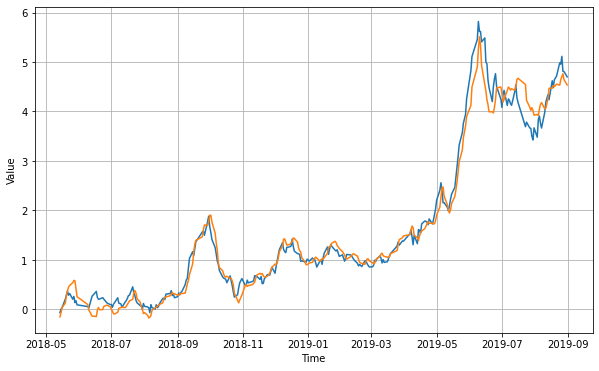

In [124]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [125]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

0.16192827

In [126]:
print(rnn_forecast)

# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[-1.51212335e-01 -6.69704750e-02  3.65739688e-02  1.26516640e-01
  2.78192401e-01  3.70996177e-01  4.45297927e-01  4.83140439e-01
  5.40081680e-01  5.86588204e-01  5.79194844e-01  4.22637254e-01
  2.57278413e-01  9.86631960e-02 -1.05578452e-02 -1.35228410e-01
 -1.43034756e-01 -1.61385164e-02  3.93573195e-02 -5.50579280e-03
 -4.63239849e-03  6.20841980e-02  8.74971971e-02  5.36525622e-02
  4.38001007e-03 -3.10689211e-02 -8.76313075e-02 -9.22786072e-02
 -5.89946285e-02  2.14297324e-02  4.03756276e-02  4.64115292e-02
  3.51566821e-02  6.27269968e-02  9.99217853e-02  1.41021043e-01
  1.72953486e-01  2.03381658e-01  3.37295800e-01  3.83142948e-01
  3.38216126e-01  2.21018866e-01  1.45287439e-01  5.71459532e-02
  3.13203782e-03 -8.23756680e-02 -6.44017011e-02 -1.21074356e-01
 -1.72668517e-01 -1.56518996e-01 -1.28423423e-01 -1.78184360e-02
  3.21732834e-02  4.09750268e-02  6.81567937e-02  8.74230638e-02
  1.00543164e-01  1.31548017e-01  2.00318173e-01  2.46054858e-01
  2.51369357e-01  2.76787